<a href="https://colab.research.google.com/github/NadAAaHH/SDAIA_T5_NLP_project/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Load the data

In [ ]:
import numpy as np 
import pandas as pd
import string as st
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
from scipy import linalg
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
# run only once
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
df = pd.read_csv(r'C:\Users\Nadar\OneDrive\Desktop\SDAIA\NLP\appleStore_description.csv')
df_info = pd.read_csv(r'C:\Users\Nadar\OneDrive\Desktop\SDAIA\NLP\AppleStore.csv')

In [ ]:
df_info.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [ ]:
df_info = df_info[['id', 'track_name', 'user_rating', 'prime_genre']]

In [ ]:
df_info.head()

,id,track_name,user_rating,prime_genre
0,281656475,PAC-MAN Premium,4.0,Games
1,281796108,Evernote - stay organized,4.0,Productivity
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",3.5,Weather
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",4.0,Shopping
4,282935706,Bible,4.5,Reference


In [ ]:
# take only the apps that have a rating above 4 then sort by ratings
df_filtered = df_info[df_info.user_rating > 4].sort_values(by=['user_rating'], ascending=False)

In [ ]:
print(df_filtered['prime_genre'].value_counts())

Games                1941
Photo & Video         184
Education             158
Entertainment         144
Health & Fitness      105
Productivity           91
Utilities              74
Music                  64
Shopping               53
Book                   44
Social Networking      41
Lifestyle              37
Reference              29
Travel                 29
Business               26
Weather                26
Finance                24
Food & Drink           21
Sports                 21
Navigation             14
News                   14
Medical                13
Catalogs                2
Name: prime_genre, dtype: int64


In [ ]:
# merge Entertainment and Games
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Entertainment' if x == 'Games' else x)
# merge Productivity and Utilities
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Productivity' if x == 'Utilities' else x)
# merge Finance and Business
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Business' if x == 'Finance' else x)
# merge Book and Reference
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Book' if x == 'Reference' else x)
# merge Health & Fitness and Medical
#df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Health & Fitness' if x == 'Medical' else x)

In [ ]:
# remove all apps of minimum genre
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Lifestyle']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Catalogs']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Navigation']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'News']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Business']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Medical']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Entertainment']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Sports']

In [ ]:
print(df_filtered['prime_genre'].value_counts())

Photo & Video        184
Productivity         165
Education            158
Health & Fitness     105
Book                  73
Music                 64
Shopping              53
Social Networking     41
Travel                29
Weather               26
Food & Drink          21
Name: prime_genre, dtype: int64


In [ ]:
# get only apps that exsit after filtering
df = df[df['id'].isin(list(df_filtered['id']))]

In [ ]:
# due to their diversity, exclude all apps of Games genre
df_filtered = df_filtered.reset_index()
df = df.reset_index()

In [ ]:
df_filtered.shape

(919, 5)

In [ ]:
df.shape

(919, 5)

In [ ]:
topics = list(df_filtered['prime_genre'].unique())
print(topics)

['Productivity', 'Photo & Video', 'Education', 'Music', 'Book', 'Health & Fitness', 'Social Networking', 'Shopping', 'Travel', 'Food & Drink', 'Weather']


### Step 2: Prepare the data

### Text cleaning and processing steps
1. Remove URLs
2. Remove punctuations  
3. Remove non-alphabetic  characters
4. Lower casing
5. Convert text to tokens  
6. Remove stopwords    
7. Apply lemmatization  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect
from wordcloud import WordCloud

In [ ]:
def precosseing_pipeline(text):
    if detect('convert words to feature vectors') == 'en':
        # remove urls
        text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', ' ', text)
        # remove punctuations 
        text = ("".join([ch for ch in text if ch not in st.punctuation]))
        # remove non-alphanumeric characters
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        # lower casing
        text = text.lower()
        # convert text to tokens
        text = re.split('\s+' ,text)
        tokens = [x.lower() for x in text]
        # remove stopwords using NLTK corpus stopwords list to match
        tokens = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
        # apply lemmatization
        word_net = WordNetLemmatizer()
        tokens = [word_net.lemmatize(word) for word in tokens]
        # convert words to feature vectors
        text = " ".join([word for word in tokens])
    else:
        text = np.nan
        
    return text

In [ ]:
df['processed_desc'] = df['app_desc'].apply(lambda x : precosseing_pipeline(x) if len(precosseing_pipeline(x)) > 100 else np.nan)

In [ ]:
df.head()

,index,id,track_name,size_bytes,app_desc,processed_desc
0,4,282935706,Bible,92774400,On more than 250 million devices around the wo...,million device around world people reading lis...
1,8,284666222,PCalc - The Best Calculator,49250304,"PCalc is the powerful choice for scientists, e...",pcalc powerful choice scientist engineer stude...
2,20,285946052,iQuran,70707916,** iPray for Mac OS X is OUT **\n\n***********...,ipray mac o x news iquran sold fraction origi...
3,31,289084315,Period Tracker Deluxe,40216576,"Period Tracker, the easiest way to track your ...",period tracker easiest way track health suppor...
4,38,291430598,Hurricane Pro,29518848,Hurricane Pro: The best Hurricane tracker app ...,hurricane pro best hurricane tracker app iphon...


In [ ]:
# explore null values 
df[list(df.columns)].isnull().sum()

index              0
id                 0
track_name         0
size_bytes         0
app_desc           0
processed_desc    64
dtype: int64

In [ ]:
# drop NaNs
df = df.dropna()

In [ ]:
# explore null values 
df[list(df.columns)].isnull().sum()

index             0
id                0
track_name        0
size_bytes        0
app_desc          0
processed_desc    0
dtype: int64

In [ ]:
df.shape

(855, 6)

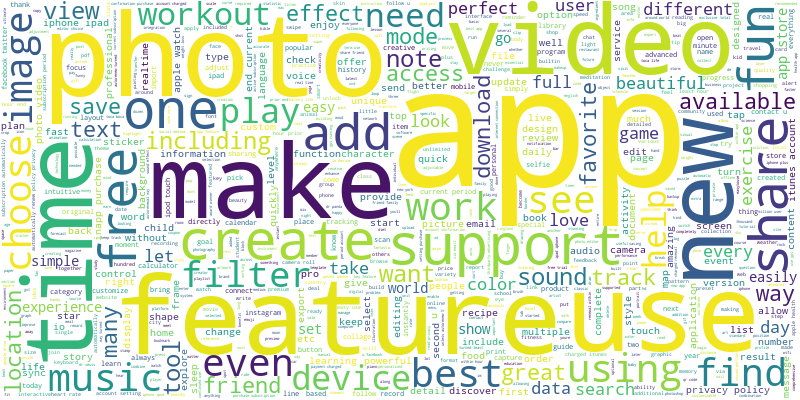

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(df['processed_desc'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
df['processed_desc'] = df['processed_desc'].apply(lambda x : re.sub('game | play | app | use | feature | new | make | apps | time | subscription | iphone | ipad | privacy | policy', '', x))

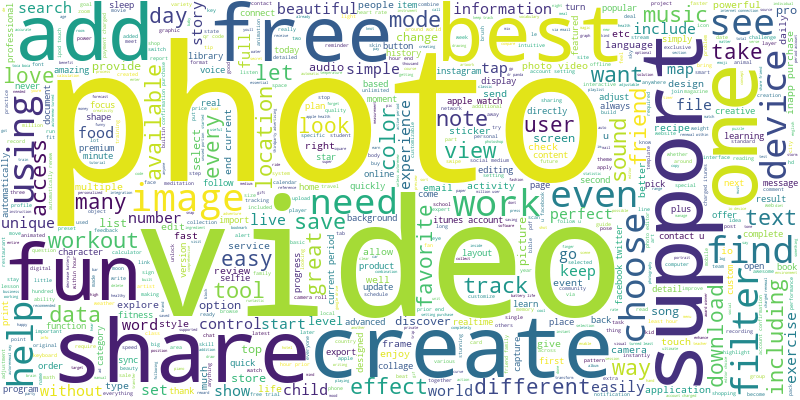

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(df['processed_desc'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Define CountVectorizer
cv = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
                            )

# Apply it to the dataset
document_word_matrix = cv.fit_transform(df["processed_desc"])

In [ ]:
# use tfidf by removing tokens that don't appear in at least 10 documents
vect = TfidfVectorizer(
                        min_df=10, 
                        stop_words='english', 
                        token_pattern='[a-zA-Z0-9]{3,}'
                    )

 
# Fit and transform
X = vect.fit_transform(df['processed_desc'])

### Step 3: Try LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
lsa = TruncatedSVD(n_components=10)

doc_topic = lsa.fit_transform(document_word_matrix)
lsa.explained_variance_ratio_

array([0.03707861, 0.03936383, 0.02652191, 0.02420534, 0.02192909,
       0.01918068, 0.01456105, 0.01437575, 0.01423599, 0.01290063])

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer, model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
topic_keywords = show_topics(vectorizer=cv, model=lsa, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,photo,video,share,create,free,like,add,filter,effect,text
Topic 1,photo,video,collage,effect,filter,camera,frame,instagram,editing,sticker
Topic 2,weather,photo,map,forecast,location,alert,radar,storm,data,day
Topic 3,video,weather,forecast,radar,map,alert,current,storm,speed,location
Topic 4,workout,exercise,photo,fitness,weight,account,training,period,plan,food
Topic 5,file,pdf,document,text,support,note,cloud,device,image,scan
Topic 6,workout,sleep,sound,exercise,fitness,effect,meditation,mode,weather,support
Topic 7,sleep,sound,music,meditation,sky,star,song,alarm,night,period
Topic 8,sky,star,moon,event,chart,night,device,calendar,planet,constellation
Topic 9,food,life,sleep,recipe,toca,card,product,day,friend,share


### Step 4: Try LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 11, 12, 13], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(document_word_matrix)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 11, 12, 13]})

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(document_word_matrix))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -166589.99130347633
Model Perplexity:  875.0068314022682


In [ ]:
topic_keywords = show_topics(vectorizer=cv, model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,weather,photo,map,tool,forecast,location,color,storm,alert,data
Topic 1,video,store,best,state,deal,save,location,product,free,shop
Topic 2,kid,fun,world,toca,life,friend,like,meditation,story,explore
Topic 3,photo,video,effect,filter,camera,calculator,mode,collage,frame,calculation
Topic 4,file,device,support,note,event,email,search,document,photo,view
Topic 5,child,word,fun,number,learning,learn,math,kid,award,book
Topic 6,account,period,current,end,free,purchase,hour,charged,user,itunes
Topic 7,sound,sleep,star,sky,audio,moon,support,mode,map,music
Topic 8,photo,create,image,text,share,add,tool,instagram,color,design
Topic 9,workout,exercise,fitness,apple,track,food,health,weight,training,day


### Step 5: Try NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
# Create an NMF instance: model
# the 12 components will be the topics
model = NMF(n_components=10, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

C:\Users\Nadar\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [ ]:
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,aac,abc,ability,able,absolutely,academic,access,accessible,accessory,according,...,yearly,yoga,youll,young,youre,youtube,youve,zip,zone,zoom
0,0.000000,0.000000,0.043885,0.003477,0.010325,0.000000,0.005548,0.000000,0.005432,0.000000,...,0.006310,0.000000,0.038124,0.000000,0.037263,0.000000,0.013499,0.000000,0.001977,0.083217
1,0.000000,0.039790,0.035251,0.016395,0.031310,0.061083,0.004136,0.007054,0.021234,0.009334,...,0.000000,0.002172,0.030496,0.093058,0.010687,0.008961,0.016257,0.000000,0.000000,0.001055
2,0.000000,0.000395,0.064378,0.002953,0.031761,0.000000,0.036607,0.000000,0.000000,0.005038,...,0.025469,0.092437,0.000450,0.000000,0.008634,0.000000,0.012755,0.000000,0.017661,0.000000
3,0.000000,0.015722,0.008172,0.002822,0.000000,0.000000,0.016687,0.012394,0.000000,0.000000,...,0.001271,0.000000,0.005448,0.000000,0.001342,0.000000,0.007579,0.000000,0.003056,0.012531
4,0.005502,0.001408,0.000000,0.027090,0.004116,0.000000,0.103492,0.000000,0.000000,0.014322,...,0.092807,0.000000,0.020872,0.000000,0.011294,0.000000,0.000000,0.000000,0.010971,0.000000
5,0.019270,0.000000,0.029470,0.015568,0.003942,0.000000,0.127460,0.021258,0.000000,0.000000,...,0.000000,0.000000,0.003359,0.000000,0.028084,0.000000,0.000996,0.054602,0.003439,0.019000
6,0.000000,0.000000,0.000000,0.028882,0.006150,0.000000,0.043797,0.000000,0.000000,0.000000,...,0.001004,0.011815,0.011389,0.000000,0.009524,0.145108,0.000000,0.000000,0.000000,0.069218
7,0.000000,0.010757,0.002863,0.004981,0.012645,0.000000,0.086238,0.000000,0.034374,0.012460,...,0.000000,0.007200,0.033038,0.000000,0.038603,0.000575,0.022792,0.000000,0.006412,0.000000
8,0.013378,0.000000,0.020427,0.002142,0.007782,0.000000,0.033536,0.000000,0.000707,0.001705,...,0.000000,0.019721,0.011362,0.005021,0.003934,0.032173,0.004053,0.000000,0.000000,0.000290
9,0.000000,0.003462,0.014637,0.007399,0.000000,0.000000,0.015433,0.049858,0.000020,0.000000,...,0.000000,0.000000,0.000000,0.002517,0.005396,0.000000,0.001254,0.000000,0.000000,0.039171


In [ ]:
topic_keywords = show_topics(vectorizer=vect, model=model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,photo,filter,collage,effect,tool,image,color,camera,frame,sticker
Topic 1,kid,child,fun,word,panda,learn,parent,activity,award,learning
Topic 2,workout,exercise,fitness,training,weight,plan,body,minute,goal,runtastic
Topic 3,weather,map,forecast,radar,location,alert,storm,current,data,snow
Topic 4,period,account,current,charged,end,month,hour,purchase,turned,renewal
Topic 5,file,document,pdf,text,note,drive,support,image,word,cloud
Topic 6,video,instagram,effect,clip,share,speed,movie,camera,photo,live
Topic 7,food,deal,item,store,shop,recipe,shopping,product,order,restaurant
Topic 8,music,sound,song,sleep,playlist,audio,meditation,artist,listen,midi
Topic 9,calculator,calculation,button,scientific,mode,basic,equation,number,function,history


### Step 6: Plot the results

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(nmf_features):
    topic_weights.append(row_list)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of LSA Topics", plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

### Plot the most discussed topic

In [ ]:
topics_count_series = pd.Series()

In [ ]:
topics_count_series.value_counts()

7    147
1    132
5    118
0    107
8     90
4     67
6     56
3     51
2     49
9     38
dtype: int64

In [ ]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

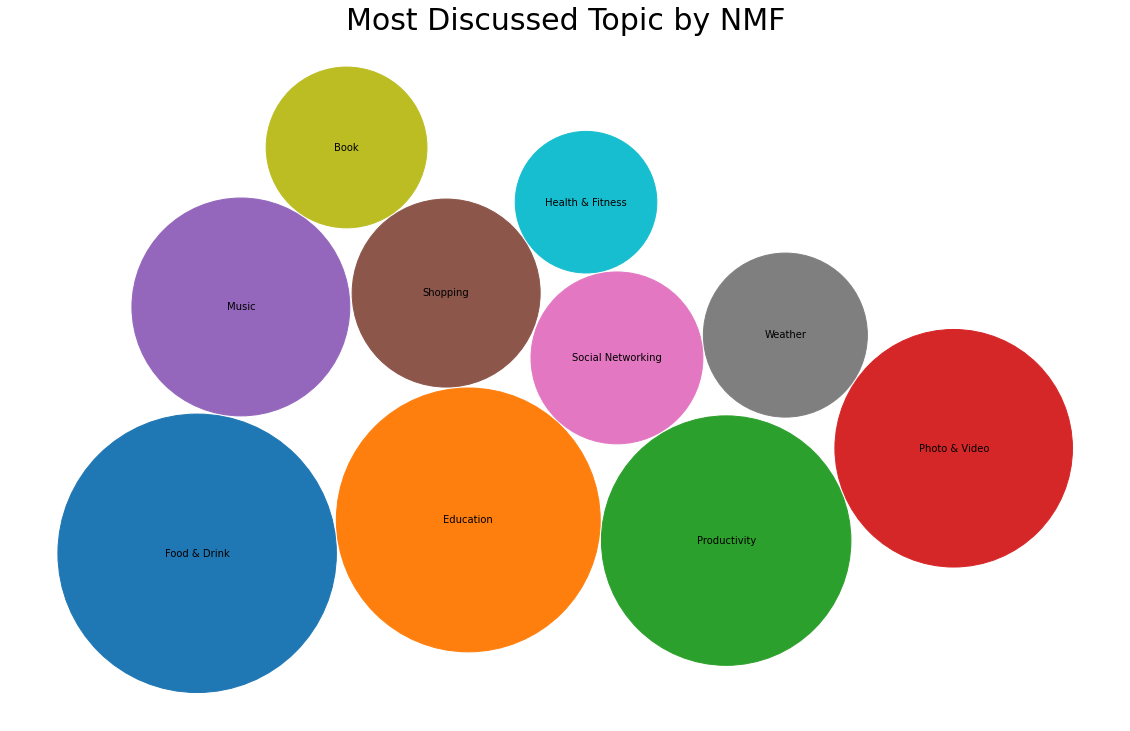

In [ ]:
bubble_chart = BubbleChart(area=values,
                           bubble_spacing=0.1)

bubble_chart.collapse()

color = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topics_bubbles = [
    'Food & Drink',
    'Education',
    'Productivity',
    'Photo & Video',
     'Music',
     'Shopping',
     'Social Networking',
     'Weather',
     'Book',
     'Health & Fitness'
]

values = list(topics_count_series.value_counts().values)

fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, topics_bubbles, color)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Most Discussed Topic by NMF', fontsize=30)

plt.show()